##Emotion Recognition

Dataset: Emotion Recognition Data
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Using the face expression recognition dataset, build your own CNN model to optimize
the recognition performance based on knowledge we learned so far. Your team reports
overall accuracy, confusion matrix, training/validation curves of accuracy and loss, and
python code with detailed comments (Jupyter Notebook with instance code results)

**Presetup and Data Extraction**

The below steps prepares the environment in Google Colab by checking GPU availability, uploading and configuring the Kaggle API key for authentication, downloading a facial expression recognition dataset from Kaggle, and extracting it for use in machine learning tasks.

In [1]:
# This checks and prints how many GPUs are available for TensorFlow to use in the current environment.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# This allows to upload a file (in this case, the Kaggle API key).
from google.colab import files
files.upload()

# we should upload the 'kaggle.json' file, which contains the Kaggle API key.
# To obtain the 'kaggle.json' file, follow these steps:
# 1. Go to https://www.kaggle.com/.
# 2. In the top-right corner, click on your profile icon and select "My Account."
# 3. Scroll down to the "API" section and click "Create New API Token."
# 4. This will download the 'kaggle.json' file to your local machine.
# 5. Upload the 'kaggle.json' file here in Colab when prompted.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mounireddy21","key":"95f15bd44c46b955ab30cb97f1bde537"}'}

In [3]:
import os
# Create a directory for storing the Kaggle API key if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)
# The directory '/root/.kaggle' is where the Kaggle API key will be placed.

# Move the Kaggle API key file (kaggle.json) into the correct directory
!mv kaggle.json /root/.kaggle/
# This moves the uploaded 'kaggle.json' file into the '.kaggle' directory.

# Set the correct file permissions for the Kaggle API key (kaggle.json)
!chmod 600 /root/.kaggle/kaggle.json
# This ensures that the Kaggle API key has restricted access, making it secure.

In [ ]:
!pip install kaggle


In [4]:
# This command uses the Kaggle API to download the face expression recognition dataset from the specified Kaggle user and dataset name.
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown


In [5]:
# This command unzips the downloaded dataset into the '/content/' directory so it can be used for further analysis or processing.
!unzip /content/face-expression-recognition-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/validation/fear/8797.jpg  
  inflating: /content/images/validation/fear/8818.jpg  
  inflating: /content/images/validation/fear/886.jpg  
  inflating: /content/images/validation/fear/9037.jpg  
  inflating: /content/images/validation/fear/9040.jpg  
  inflating: /content/images/validation/fear/9101.jpg  
  inflating: /content/images/validation/fear/911.jpg  
  inflating: /content/images/validation/fear/9179.jpg  
  inflating: /content/images/validation/fear/9205.jpg  
  inflating: /content/images/validation/fear/9232.jpg  
  inflating: /content/images/validation/fear/9251.jpg  
  inflating: /content/images/validation/fear/9261.jpg  
  inflating: /content/images/validation/fear/9281.jpg  
  inflating: /content/images/validation/fear/9302.jpg  
  inflating: /content/images/validation/fear/9333.jpg  
  inflating: /content/images/validation/fear/9369.jpg  
  inflating: /content/images/validation/fear/9370.jpg  

# Step 1: Importing libraries and Data Loading

In this step, we import all the necessary libraries for data manipulation, visualization, deep learning, and image processing. These libraries are essential for tasks like handling numerical data, plotting graphs, building and training deep learning models, and working with image data.

We define the paths for the training and testing datasets stored in the `/content/images` directory. After that, we create a custom function, `loadDataset()`, to convert the folder structure of the images into a list of file paths and their corresponding labels. This function helps in organizing the data by scanning the subdirectories, collecting the paths of the images, and associating each image with its respective label based on the folder name.

By the end of this step, the environment is fully set up, and the dataset is organized and ready for further processing, such as data augmentation or model training, in the next stages of the project.

In [6]:

# For numerical operations and data manipulation
import numpy as np
import pandas as pd

# For working with files and directories
import os

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings management
import warnings
warnings.filterwarnings('ignore')  # Suppressing unnecessary warnings

# For generating random numbers
import random

# For progress bar in loops (useful in Jupyter notebooks)
from tqdm.notebook import tqdm

## Deep Learning & Image Processing Libraries
# TensorFlow and Keras for building and training models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

## Machine Learning Utilities
# For evaluating model performance
from sklearn.metrics import confusion_matrix, classification_report

# For handling imbalanced classes
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

# For label encoding
from sklearn.preprocessing import LabelEncoder

# This is for inline plotting in Jupyter notebooks
%matplotlib inline

from PIL import Image, ImageEnhance
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
# to view the current working directory to check where the notebook is running
print(os.getcwd())
# This lists all files present in the '/content' directory, which is where files are typically stored in Colab.
os.listdir('/content')


/content


['.config', 'images', 'face-expression-recognition-dataset.zip', 'sample_data']

In [8]:
# Defien the directory path for the training and testing dataset
TRAIN_DIR = '/content/images/train/'
TEST_DIR = '/content/images/validation/'


In [9]:
# converting the folder structure into a csv
# A custom function loadDataset() is defined to convert the folder structure
#  (with subdirectories for each class) into a list of image paths and their
# corresponding labels. This function iterates through each label (class) folder,
# collects the image file paths, and associates them with their respective labels.
#
# The function returns two lists: image_paths (paths to all images) and labels (corresponding labels for each image).
def loadDataset(directory):
    image_paths = []  # List to hold the paths of all images
    labels = []  # List to hold the labels (classes of the images)

    for label in os.listdir(directory):  # Loop through each subdirectory (label)
        for filename in os.listdir(directory + label):  # Loop through the files inside each label directory
            image_path = os.path.join(directory, label, filename)  # Construct the full path to the image
            image_paths.append(image_path)  # Add the image path to the image_paths list
            labels.append(label)  # Add the label (subdirectory name) to the labels list

        # print(label, "Completed")  # Print the progress for each label (class)

    return image_paths, labels  # Return the lists of image paths and corresponding labels



# Step 2: Data Organization and Visual Inspection

In this step, we convert the loaded dataset into pandas DataFrames (train and test) for easy manipulation. The data is shuffled to ensure randomness before training the model. Additionally, we explore the data through visualizations to understand class distribution and check if any class imbalance exists. We also display some sample images from the dataset to ensure they are loaded correctly.

By the end of this step, the data is organized and visually inspected, allowing for further preprocessing and model training in subsequent steps.

In [10]:
# Convert the loaded dataset into a pandas DataFrame for the training set
train = pd.DataFrame()
train['image'], train['label'] = loadDataset(TRAIN_DIR)  # Assign image paths and labels to the DataFrame

# Shuffle the dataset to ensure random order for training
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train.head()


,image,label
0,/content/images/train/happy/31298.jpg,happy
1,/content/images/train/happy/7012.jpg,happy
2,/content/images/train/surprise/6257.jpg,surprise
3,/content/images/train/fear/12479.jpg,fear
4,/content/images/train/neutral/3485.jpg,neutral


In [11]:
# Convert the loaded dataset into a pandas DataFrame for the testing set
test = pd.DataFrame()
test['image'], test['label'] = loadDataset(TEST_DIR)
test.head()

,image,label
0,/content/images/validation/angry/24428.jpg,angry
1,/content/images/validation/angry/1555.jpg,angry
2,/content/images/validation/angry/11949.jpg,angry
3,/content/images/validation/angry/18415.jpg,angry
4,/content/images/validation/angry/27544.jpg,angry


Class distribution in the training dataset:
label
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: count, dtype: int64


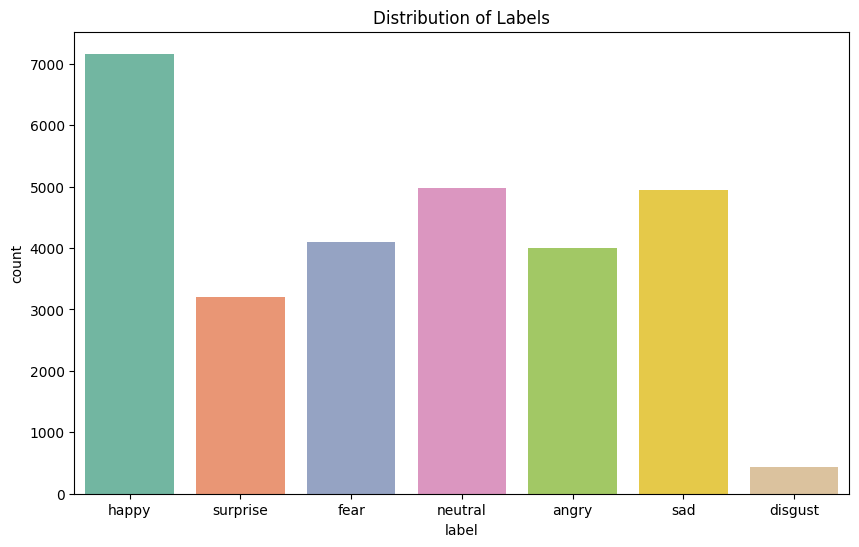

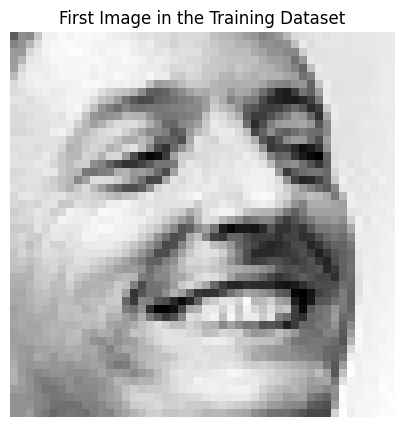

In [13]:
# Print the class distribution (number of samples in each class)
class_counts = train['label'].value_counts()  # Count the number of images per label
print("Class distribution in the training dataset:")
print(class_counts)

# Visualize the distribution of labels in the training dataset using a count plot
plt.figure(figsize=(10, 6))
plt.title('Distribution of Labels')
sns.countplot(x='label', data=train, palette='Set2')
plt.show()

# Display the first image in the training dataset to ensure images are loaded correctly
img = Image.open(train['image'][0])
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')  # Display the image in grayscale
plt.title("First Image in the Training Dataset")
plt.axis('off')
plt.show()

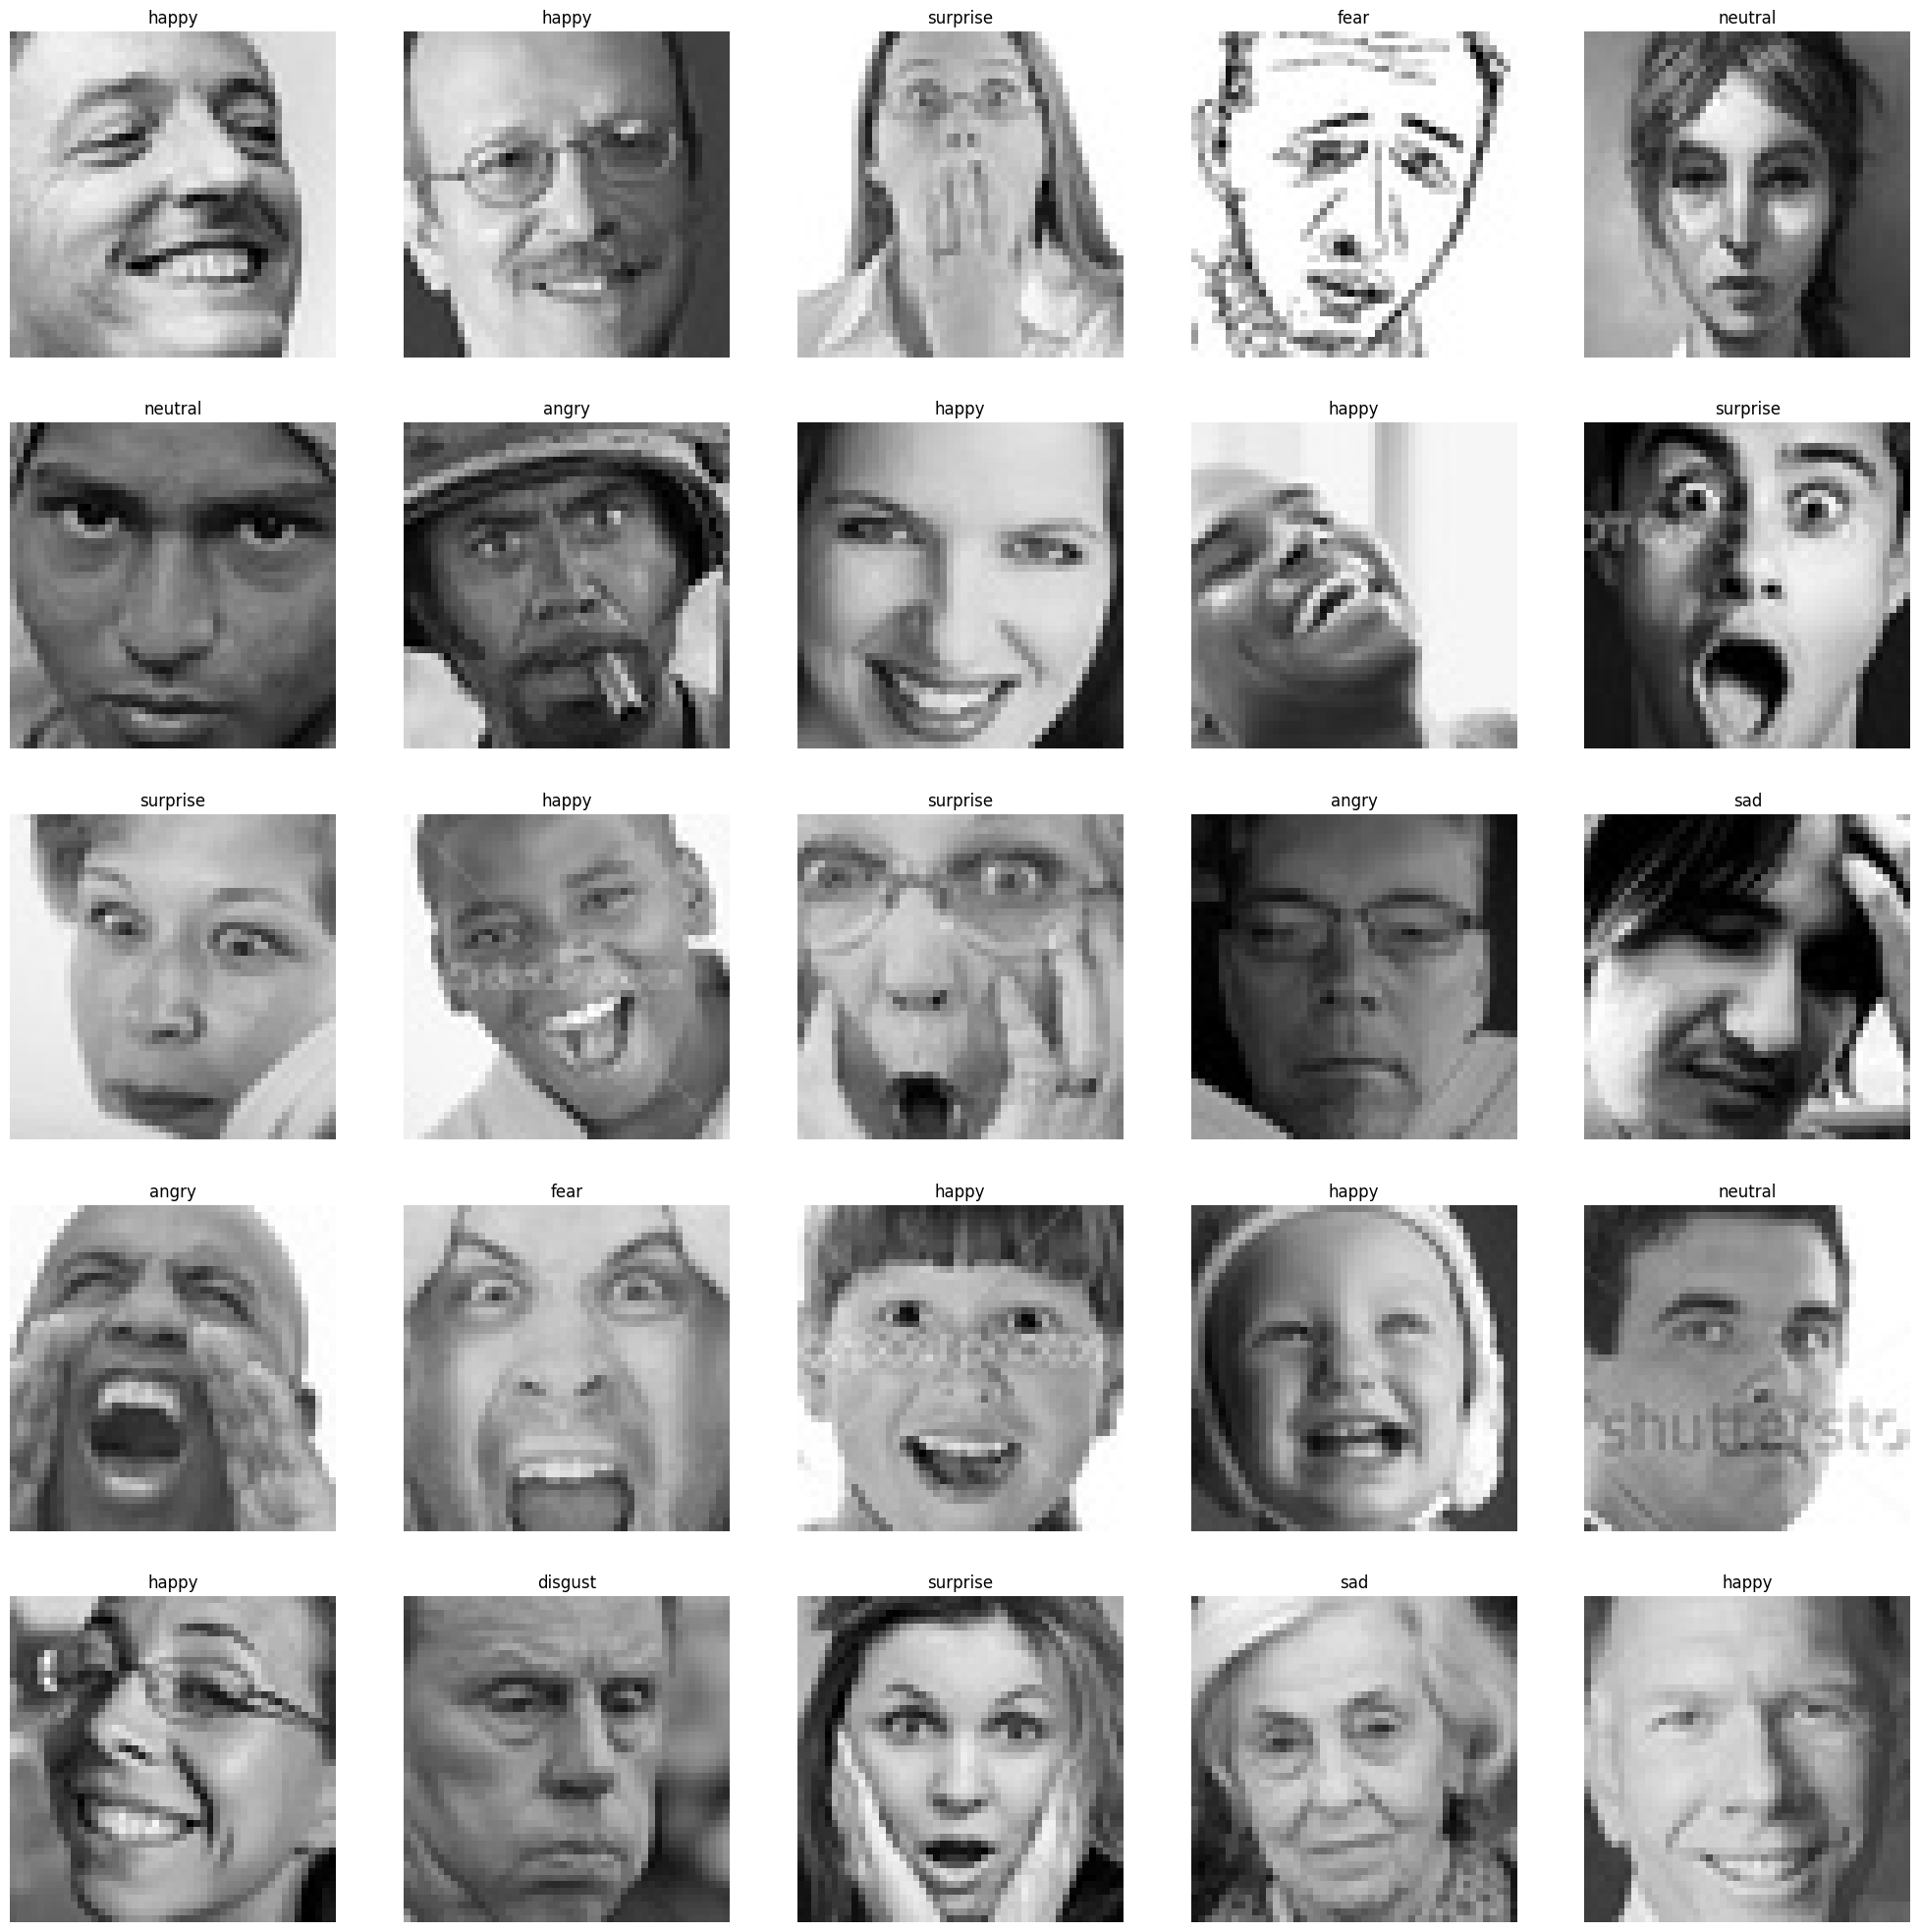

In [14]:
# Displaying a grid of the first 25 images from the training set for inspection
plt.figure(figsize=(25, 25))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# Step 3: Image Preprocessing and Feature Extraction

In this step, we implement various image preprocessing techniques to enhance the quality of the images before feeding them into the model. These preprocessing techniques include resizing, sharpening, contrast adjustment, and normalization. We also extract features from the images and prepare the dataset for model training by converting the images into numerical arrays. The labels are encoded and one-hot encoded for use in classification tasks.

In [25]:
## Image Preprocessing:
# 1. Resizing: Each image is resized to a target size of 48x48 pixels to ensure consistency in input dimensions.

# Resize the image to target size (default: 48x48)
def resize_image(image_path, target_size=(48, 48)):
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize with high-quality downsampling
    return img_resized

# Main function to apply the entire preprocessing pipeline
def preprocess_image(image, target_size=(48, 48)):
    # Apply resizing
    img_resized = resize_image(image, target_size)

    return img_resized

The extractFeatures() and extracttestFeatures() functions process the training and test images, applying the preprocessing pipeline and converting each image into a numerical array suitable for model input.

In [26]:
# Extract features from the list of images for the training dataset
def extractFeatures(images):
    features = []
    target_size=(48, 48)
    for image in tqdm(images):
        img = preprocess_image(image, target_size)  # Apply the preprocessing pipeline
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1) # Reshape for model input
    return features

In [27]:
# -------Extract features for the test dataset----------
# The test dataset is intended to be used for model evaluation after training,
# and since the images are already in a suitable format (grayscale and resized via load_img()),
# there is no need to apply additional preprocessing steps like resizing, sharpening,
# or contrast adjustment. This avoids unnecessary computation and ensures the test data
#  remains consistent with the format used during model training, which is crucial for accurate model evaluation.
def extracttestFeatures(images):
    features = []
    target_size=(48, 48)
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

Normalization:
*   The pixel values of the images are normalized by dividing by 255.0, scaling the values to the range [0, 1].

Label Encoding:

* The categorical labels (e.g., 'happy', 'sad') are converted into numerical values using LabelEncoder and then one-hot encoded for classification tasks.


In [28]:
# Extract features for the test images
test_features = extracttestFeatures(test['image'])

# Normalize test features by scaling pixel values between 0 and 1
x_test = test_features / 255.0

# Convert labels to numerical values using LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])  # Encode labels for the test set

# One-hot encode the labels (7 classes in this case)
y_test = to_categorical(y_test, num_classes=7)

  0%|          | 0/7066 [00:00<?, ?it/s]

# Step 4: Data Augmentation and Balancing

In this step, we address the class imbalance issue by augmenting underrepresented classes in the dataset. Data augmentation artificially increases the size of the dataset by applying random transformations to the images, such as rotation, scaling, and flipping. This is crucial for training deep learning models, as it improves the model's ability to generalize and prevents overfitting, particularly when dealing with imbalanced datasets. By ensuring that each class has a balanced number of samples, we can improve the accuracy and robustness of the model.

In [29]:
# Function to load and preprocess the full training dataset
def load_and_preprocess_data(train):
    # Encode labels
    le = LabelEncoder()
    le.fit(train['label'])
    y_train = le.transform(train['label'])
    y_train = to_categorical(y_train, num_classes=7)  # One-hot encoding

    # Preprocess the images
    x_train = extractFeatures(train['image'])
    x_train = x_train / 255.0  # Normalize the pixel values between 0 and 1

    return x_train, y_train, le

* Data Augmentation: This step applies data augmentation techniques (rotation, flipping, shifting, zooming, etc.) to generate additional training examples for underrepresented classes. This ensures that all classes have sufficient samples, which is crucial for model training, especially when dealing with imbalanced datasets.

* Balancing the Dataset: By augmenting the underrepresented classes, the model can be trained more effectively, reducing the risk of bias towards the more frequent classes. This improves the model's generalization and predictive performance on unseen data.

* Improving Model Performance: Augmenting the dataset helps to prevent overfitting by introducing variability in the training data, allowing the model to learn more robust features.

By the end of this step, the dataset is balanced, and augmented images are added to the original dataset, ready for training the deep learning model.

In [30]:
# Set a target class count for balancing
target_class_count = 7000  # Target count to match the largest class (e.g., 'happy' class)

# Function to get the class distribution in the dataset
def get_class_distribution(train, le):
    # Ensure that train['label'] is one-hot encoded
    if len(train['label'].shape) > 1:  # Check if it is one-hot encoded
        labels_decoded = le.inverse_transform(np.argmax(train['label'], axis=1))
    else:
        labels_decoded = train['label']  # If it's already in integer form, no need to apply np.argmax

    df = pd.DataFrame({'label': labels_decoded})
    class_counts = df['label'].value_counts()
    return class_counts

# Generalize the augmentation function for underrepresented classes
def augment_classes(train, selected_classes, target_class_count, target_size=(48, 48), augmentation_params=None):
    if augmentation_params is None:
        augmentation_params = {
            'rotation_range': 30,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'shear_range': 0.2,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'brightness_range': [0.8, 1.2],    # Random brightness adjustment
            'fill_mode': 'nearest'
        }

    datagen = ImageDataGenerator(**augmentation_params)

    augmented_images = []
    augmented_labels = []

    # Loop through the selected underrepresented classes and augment
    for class_name in selected_classes:
        class_data = train[train['label'] == class_name]

        # Calculate how many more samples are needed for this class
        current_count = len(class_data)
        additional_samples_needed = target_class_count - current_count
        print(class_name, "----", additional_samples_needed)

        if additional_samples_needed > 0:
            # Preprocess images for the class
            class_images = extractFeatures(class_data['image'])
            class_images = class_images.reshape((class_images.shape[0], target_size[0], target_size[1], 1))  # Reshape for ImageDataGenerator
            class_labels = le.transform(class_data['label'])  # Label encode the classes
            class_labels = to_categorical(class_labels, num_classes=7)  # One-hot encode labels

            # Apply augmentation using ImageDataGenerator
            for batch in datagen.flow(class_images, class_labels, batch_size=32, save_to_dir=None):
                augmented_images.append(batch[0])
                augmented_labels.append(batch[1])

                # Stop augmenting once we have enough additional samples
                if len(augmented_images) * 32 >= additional_samples_needed:
                  # print(class_name, "===", len(augmented_images))
                  break

    augmented_images = np.vstack(augmented_images)  # Combine all augmented images
    augmented_labels = np.vstack(augmented_labels)  # Combine all augmented labels
    return augmented_images, augmented_labels

  0%|          | 0/28821 [00:00<?, ?it/s]

neutral ---- 2018


  0%|          | 0/4982 [00:00<?, ?it/s]

sad ---- 2062


  0%|          | 0/4938 [00:00<?, ?it/s]

fear ---- 2897


  0%|          | 0/4103 [00:00<?, ?it/s]

angry ---- 3007


  0%|          | 0/3993 [00:00<?, ?it/s]

surprise ---- 3795


  0%|          | 0/3205 [00:00<?, ?it/s]

disgust ---- 6564


  0%|          | 0/436 [00:00<?, ?it/s]

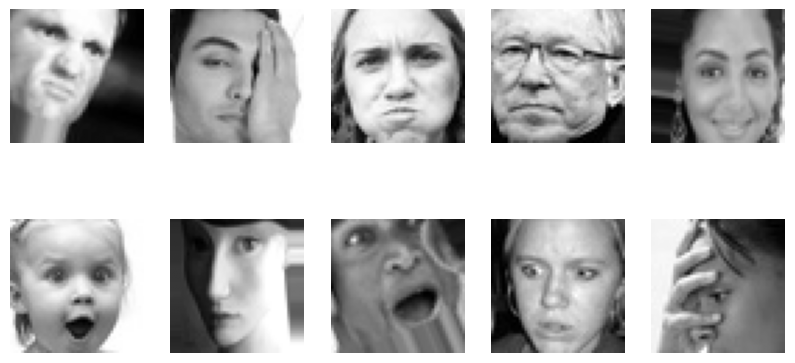

In [31]:
# Load and preprocess training data
x_train, y_train, le = load_and_preprocess_data(train)

# Get the current class distribution in the training dataset
class_counts = get_class_distribution(train, le)

# Identify underrepresented classes
# Check which classes are underrepresented (i.e., their count is less than the target)
underrepresented_classes = [class_name for class_name, count in class_counts.items() if count < target_class_count]

# Augment the selected underrepresented classes
augmented_images, augmented_labels = augment_classes(train, underrepresented_classes, target_class_count)

# Normalize augmented images to the range [0, 1]
augmented_images = augmented_images / 255.0

# Combine the augmented images with the original dataset
x_train_augmented = np.concatenate([x_train, augmented_images], axis=0)
y_train_augmented = np.concatenate([y_train, augmented_labels], axis=0)

# Shuffle the augmented dataset
x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented)

# Visualize some augmented images (optional)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_augmented[i].reshape(48, 48), cmap='gray')
    ax.axis('off')
plt.show()

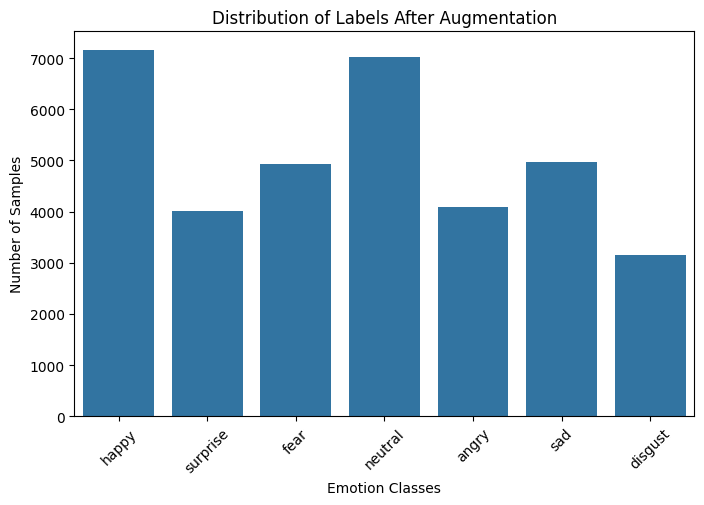

In [32]:
# Combine original and augmented labels
y_train_combined = np.concatenate([y_train, augmented_labels], axis=0)

# Decode the one-hot encoded labels back to their original class labels (if using one-hot encoding)
y_train_combined_labels = le.inverse_transform(np.argmax(y_train_combined, axis=1))

# Create a DataFrame to easily plot the distribution
df = pd.DataFrame({'label': y_train_combined_labels})

# Plot the distribution of labels
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels After Augmentation')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Step 5: Model Architecture, Compilation, and Training

In this step, we define, compile, and train a Convolutional Neural Network (CNN) model for facial emotion recognition. The model consists of multiple convolutional layers (Conv2D) followed by batch normalization, max-pooling, and dropout layers to prevent overfitting and extract high-level features from the input images. The model concludes with fully connected layers and a softmax output layer to classify the input into one of the 7 emotion categories.

**Key steps:**

**1.Model Architecture:**

The model starts with a series of convolutional layers for feature extraction, each followed by max-pooling and dropout to reduce overfitting.
The final layers flatten the output, followed by a dense layer with ReLU activation and a softmax output layer for classification.

**2. Compilation:**

The Adam optimizer is used with a learning rate of 0.0001, and the model is compiled with categorical crossentropy loss and accuracy as the evaluation metric.

**3. Callbacks:**

ReduceLROnPlateau: Reduces the learning rate if the validation loss plateaus.

*   ReduceLROnPlateau: Reduces the learning rate if the validation loss plateaus.
*   EarlyStopping: Stops training if the validation loss does not improve after a specified number of epochs.
* ModelCheckpoint: Saves the best model based on validation loss.

**4. Class Weighting:**

Class weights are calculated to handle class imbalance in the dataset, ensuring the model gives more importance to underrepresented classes during training.

**5. Training:**

The model is trained using the augmented dataset with a batch size of 64 and a maximum of 500 epochs. The validation data is used to evaluate the model's performance during training.

**6. Saving the Model:**

After training, the model is saved as face_touch_final_model.h5 for future use in inference.

Overall, this step 5 is crucial for model training, ensuring that it generalizes well by using proper regularization, balancing the class distribution, and using callbacks to fine-tune training.

In [33]:
# Configuration for input shape and number of output classes (7 emotions)
input_shape = (48, 48, 1)
output_class = 7

# Define the model architecture using Sequential API
model = Sequential()

# Layer 1: Convolutional Layer with 32 filters and L2 regularization
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())  # Normalize activations to improve convergence
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling to downsample the feature maps
model.add(Dropout(0.4))  # Dropout to prevent overfitting

# Layer 2: Convolutional Layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Layer 3: Convolutional Layer with 128 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Layer 4: Convolutional Layer with 512 filters
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully Connected Layer: Flatten the output from convolutional layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5)) # Dropout to reduce overfitting
model.add(Dense(output_class, activation='softmax')) # Output layer with softmax for classification


# Compile the model with Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for training optimization
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=8, min_lr=0.00001, verbose=1)  # Reduce learning rate if validation loss plateaus
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)  # Stop training if validation loss does not improve
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)  # Save best model based on validation loss

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train_augmented, axis=1)), # Classes in training data
    y=np.argmax(y_train_augmented, axis=1) # Ground truth labels
)

# Convert to dictionary for use in training
class_weights_dict = dict(enumerate(class_weights))



In [34]:

# Train the model using the augmented dataset
history = model.fit(
    x_train_augmented, y_train_augmented,  # Augmented training data
    epochs=500,
    batch_size=64,
    validation_data=(x_test, y_test),  # Validation data for performance evaluation
    class_weight=class_weights_dict,  # Use class weights to balance class distribution
    callbacks=[reduce_lr, early_stopping, model_checkpoint]  # Callbacks for optimization
)

# Save the final model
model.save('faceExpressionRecognition_Final_Model.h5')

Epoch 1/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1566 - loss: 10.3970
Epoch 1: val_loss improved from inf to 12.40236, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.1567 - loss: 10.3955 - val_accuracy: 0.0170 - val_loss: 12.4024 - learning_rate: 1.0000e-04
Epoch 2/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1676 - loss: 7.9633
Epoch 2: val_loss improved from 12.40236 to 8.14048, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1676 - loss: 7.9606 - val_accuracy: 0.0770 - val_loss: 8.1405 - learning_rate: 1.0000e-04
Epoch 3/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1775 - loss: 6.0169
Epoch 3: val_loss improved from 8.14048 to 5.19776, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1776 - loss: 6.0131 - val_accuracy: 0.2086 - val_loss: 5.1978 - learning_rate: 1.0000e-04
Epoch 4/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2239 - loss: 4.4970
Epoch 4: val_loss improved from 5.19776 to 3.89311, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2239 - loss: 4.4954 - val_accuracy: 0.2798 - val_loss: 3.8931 - learning_rate: 1.0000e-04
Epoch 5/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2656 - loss: 3.4748
Epoch 5: val_loss improved from 3.89311 to 2.96927, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2656 - loss: 3.4744 - val_accuracy: 0.3340 - val_loss: 2.9693 - learning_rate: 1.0000e-04
Epoch 6/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3102 - loss: 2.8287
Epoch 6: val_loss improved from 2.96927 to 2.43481, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3103 - loss: 2.8283 - val_accuracy: 0.3898 - val_loss: 2.4348 - learning_rate: 1.0000e-04
Epoch 7/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3434 - loss: 2.4430
Epoch 7: val_loss improved from 2.43481 to 2.13200, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3434 - loss: 2.4427 - val_accuracy: 0.4299 - val_loss: 2.1320 - learning_rate: 1.0000e-04
Epoch 8/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3771 - loss: 2.2009
Epoch 8: val_loss improved from 2.13200 to 1.95371, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3772 - loss: 2.2005 - val_accuracy: 0.4522 - val_loss: 1.9537 - learning_rate: 1.0000e-04
Epoch 9/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4014 - loss: 2.0443
Epoch 9: val_loss did not improve from 1.95371
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4014 - loss: 2.0442 - val_accuracy: 0.4318 - val_loss: 1.9601 - learning_rate: 1.0000e-04
Epoch 10/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4186 - loss: 1.9334
Epoch 10: val_loss improved from 1.95371 to 1.73340, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4186 - loss: 1.9333 - val_accuracy: 0.5010 - val_loss: 1.7334 - learning_rate: 1.0000e-04
Epoch 11/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4407 - loss: 1.8523
Epoch 11: val_loss improved from 1.73340 to 1.66461, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4407 - loss: 1.8522 - val_accuracy: 0.5139 - val_loss: 1.6646 - learning_rate: 1.0000e-04
Epoch 12/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4609 - loss: 1.7735
Epoch 12: val_loss improved from 1.66461 to 1.62577, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4609 - loss: 1.7734 - val_accuracy: 0.5144 - val_loss: 1.6258 - learning_rate: 1.0000e-04
Epoch 13/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4710 - loss: 1.7307
Epoch 13: val_loss improved from 1.62577 to 1.60591, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4710 - loss: 1.7306 - val_accuracy: 0.5262 - val_loss: 1.6059 - learning_rate: 1.0000e-04
Epoch 14/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4907 - loss: 1.6801
Epoch 14: val_loss improved from 1.60591 to 1.54241, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4907 - loss: 1.6801 - val_accuracy: 0.5518 - val_loss: 1.5424 - learning_rate: 1.0000e-04
Epoch 15/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5038 - loss: 1.6376
Epoch 15: val_loss improved from 1.54241 to 1.53725, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5038 - loss: 1.6376 - val_accuracy: 0.5403 - val_loss: 1.5372 - learning_rate: 1.0000e-04
Epoch 16/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5114 - loss: 1.6192
Epoch 16: val_loss improved from 1.53725 to 1.52355, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5114 - loss: 1.6191 - val_accuracy: 0.5485 - val_loss: 1.5235 - learning_rate: 1.0000e-04
Epoch 17/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5067 - loss: 1.6111
Epoch 17: val_loss improved from 1.52355 to 1.50321, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5068 - loss: 1.6110 - val_accuracy: 0.5631 - val_loss: 1.5032 - learning_rate: 1.0000e-04
Epoch 18/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5311 - loss: 1.5694
Epoch 18: val_loss improved from 1.50321 to 1.49761, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5310 - loss: 1.5694 - val_accuracy: 0.5599 - val_loss: 1.4976 - learning_rate: 1.0000e-04
Epoch 19/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5394 - loss: 1.5384
Epoch 19: val_loss improved from 1.49761 to 1.47575, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5394 - loss: 1.5384 - val_accuracy: 0.5701 - val_loss: 1.4757 - learning_rate: 1.0000e-04
Epoch 20/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5438 - loss: 1.5338
Epoch 20: val_loss did not improve from 1.47575
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5438 - loss: 1.5339 - val_accuracy: 0.5718 - val_loss: 1.4782 - learning_rate: 1.0000e-04
Epoch 21/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5479 - loss: 1.5123
Epoch 21: val_loss improved from 1.47575 to 1.45965, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5478 - loss: 1.5125 - val_accuracy: 0.5814 - val_loss: 1.4596 - learning_rate: 1.0000e-04
Epoch 22/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5566 - loss: 1.5019
Epoch 22: val_loss improved from 1.45965 to 1.45446, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5566 - loss: 1.5019 - val_accuracy: 0.5866 - val_loss: 1.4545 - learning_rate: 1.0000e-04
Epoch 23/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5646 - loss: 1.4923
Epoch 23: val_loss improved from 1.45446 to 1.45191, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5646 - loss: 1.4924 - val_accuracy: 0.5839 - val_loss: 1.4519 - learning_rate: 1.0000e-04
Epoch 24/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5695 - loss: 1.4851
Epoch 24: val_loss did not improve from 1.45191
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5695 - loss: 1.4851 - val_accuracy: 0.5815 - val_loss: 1.4589 - learning_rate: 1.0000e-04
Epoch 25/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5734 - loss: 1.4823
Epoch 25: val_loss did not improve from 1.45191
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5734 - loss: 1.4824 - val_accuracy: 0.5737 - val_loss: 1.4815 - learning_rate: 1.0000e-04
Epoch 26/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5718 - loss: 1.4734
Epoch 26: val_loss did not improve from 1.45191
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5718 - loss: 1.4735 - val_accuracy: 0.5770 - val_loss: 1.4700 - learning_rate: 1.0000e-04
Epoc

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5832 - loss: 1.4564 - val_accuracy: 0.6030 - val_loss: 1.4416 - learning_rate: 1.0000e-04
Epoch 29/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5864 - loss: 1.4525
Epoch 29: val_loss did not improve from 1.44164
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5864 - loss: 1.4526 - val_accuracy: 0.6003 - val_loss: 1.4446 - learning_rate: 1.0000e-04
Epoch 30/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5850 - loss: 1.4560
Epoch 30: val_loss did not improve from 1.44164
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5850 - loss: 1.4560 - val_accuracy: 0.5935 - val_loss: 1.4656 - learning_rate: 1.0000e-04
Epoch 31/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5918 - loss: 1.4399
Epoch 31: val_loss improved from 1.44164 to 1.42615, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5918 - loss: 1.4400 - val_accuracy: 0.6090 - val_loss: 1.4262 - learning_rate: 1.0000e-04
Epoch 32/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5922 - loss: 1.4448
Epoch 32: val_loss did not improve from 1.42615
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5922 - loss: 1.4449 - val_accuracy: 0.5993 - val_loss: 1.4524 - learning_rate: 1.0000e-04
Epoch 33/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6019 - loss: 1.4328
Epoch 33: val_loss did not improve from 1.42615
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6018 - loss: 1.4330 - val_accuracy: 0.5934 - val_loss: 1.4600 - learning_rate: 1.0000e-04
Epoch 34/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5991 - loss: 1.4407
Epoch 34: val_loss did not improve from 1.42615
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5991 - loss: 1.4407 - val_accuracy: 0.6016 - val_loss: 1.4514 - learning_rate: 1.0000e-04
Epo

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6026 - loss: 1.4252 - val_accuracy: 0.6162 - val_loss: 1.4259 - learning_rate: 1.0000e-04
Epoch 36/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5973 - loss: 1.4420
Epoch 36: val_loss did not improve from 1.42590
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5973 - loss: 1.4420 - val_accuracy: 0.6094 - val_loss: 1.4400 - learning_rate: 1.0000e-04
Epoch 37/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6004 - loss: 1.4314
Epoch 37: val_loss did not improve from 1.42590
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6003 - loss: 1.4314 - val_accuracy: 0.6016 - val_loss: 1.4501 - learning_rate: 1.0000e-04
Epoch 38/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6071 - loss: 1.4183
Epoch 38: val_loss did not improve from 1.42590
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6071 - loss: 1.4184 - val_accuracy: 0.6142 - val_loss: 1.4413 - learning_rate: 1.0000e-04
Ep

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6298 - loss: 1.3666 - val_accuracy: 0.6235 - val_loss: 1.3985 - learning_rate: 7.5000e-05
Epoch 46/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6294 - loss: 1.3484
Epoch 46: val_loss did not improve from 1.39850
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6294 - loss: 1.3485 - val_accuracy: 0.6177 - val_loss: 1.4182 - learning_rate: 7.5000e-05
Epoch 47/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6346 - loss: 1.3349
Epoch 47: val_loss did not improve from 1.39850
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6345 - loss: 1.3350 - val_accuracy: 0.6217 - val_loss: 1.4046 - learning_rate: 7.5000e-05
Epoch 48/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6292 - loss: 1.3507
Epoch 48: val_loss improved from 1.39850 to 1.38555, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6292 - loss: 1.3507 - val_accuracy: 0.6244 - val_loss: 1.3856 - learning_rate: 7.5000e-05
Epoch 49/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6361 - loss: 1.3292
Epoch 49: val_loss did not improve from 1.38555
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6361 - loss: 1.3292 - val_accuracy: 0.6156 - val_loss: 1.4010 - learning_rate: 7.5000e-05
Epoch 50/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6422 - loss: 1.3186
Epoch 50: val_loss improved from 1.38555 to 1.38554, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6422 - loss: 1.3187 - val_accuracy: 0.6226 - val_loss: 1.3855 - learning_rate: 7.5000e-05
Epoch 51/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6399 - loss: 1.3145
Epoch 51: val_loss did not improve from 1.38554
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6399 - loss: 1.3146 - val_accuracy: 0.6247 - val_loss: 1.3895 - learning_rate: 7.5000e-05
Epoch 52/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6374 - loss: 1.3127
Epoch 52: val_loss did not improve from 1.38554
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6373 - loss: 1.3128 - val_accuracy: 0.6228 - val_loss: 1.3940 - learning_rate: 7.5000e-05
Epoch 53/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6403 - loss: 1.3061
Epoch 53: val_loss improved from 1.38554 to 1.38155, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6402 - loss: 1.3062 - val_accuracy: 0.6278 - val_loss: 1.3816 - learning_rate: 7.5000e-05
Epoch 54/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6395 - loss: 1.3078
Epoch 54: val_loss improved from 1.38155 to 1.36578, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6395 - loss: 1.3078 - val_accuracy: 0.6332 - val_loss: 1.3658 - learning_rate: 7.5000e-05
Epoch 55/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6449 - loss: 1.2996
Epoch 55: val_loss did not improve from 1.36578
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6449 - loss: 1.2997 - val_accuracy: 0.6250 - val_loss: 1.3913 - learning_rate: 7.5000e-05
Epoch 56/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6489 - loss: 1.2952
Epoch 56: val_loss did not improve from 1.36578
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6489 - loss: 1.2952 - val_accuracy: 0.6274 - val_loss: 1.3725 - learning_rate: 7.5000e-05
Epoch 57/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6487 - loss: 1.2830
Epoch 57: val_loss did not improve from 1.36578
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6486 - loss: 1.2832 - val_accuracy: 0.6320 - val_loss: 1.3719 - learning_rate: 7.5000e-05
Ep

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6580 - loss: 1.2634 - val_accuracy: 0.6383 - val_loss: 1.3582 - learning_rate: 5.6250e-05
Epoch 64/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6631 - loss: 1.2551
Epoch 64: val_loss did not improve from 1.35822
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6631 - loss: 1.2551 - val_accuracy: 0.6312 - val_loss: 1.3744 - learning_rate: 5.6250e-05
Epoch 65/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6675 - loss: 1.2345
Epoch 65: val_loss improved from 1.35822 to 1.34914, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6675 - loss: 1.2345 - val_accuracy: 0.6354 - val_loss: 1.3491 - learning_rate: 5.6250e-05
Epoch 66/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6690 - loss: 1.2263
Epoch 66: val_loss did not improve from 1.34914
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6690 - loss: 1.2263 - val_accuracy: 0.6374 - val_loss: 1.3510 - learning_rate: 5.6250e-05
Epoch 67/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6739 - loss: 1.2084
Epoch 67: val_loss improved from 1.34914 to 1.34207, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6738 - loss: 1.2085 - val_accuracy: 0.6371 - val_loss: 1.3421 - learning_rate: 5.6250e-05
Epoch 68/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6760 - loss: 1.1977
Epoch 68: val_loss did not improve from 1.34207
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6759 - loss: 1.1978 - val_accuracy: 0.6291 - val_loss: 1.3595 - learning_rate: 5.6250e-05
Epoch 69/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6739 - loss: 1.1981
Epoch 69: val_loss did not improve from 1.34207
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6738 - loss: 1.1982 - val_accuracy: 0.6337 - val_loss: 1.3495 - learning_rate: 5.6250e-05
Epoch 70/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6776 - loss: 1.1916
Epoch 70: val_loss improved from 1.34207 to 1.33223, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6776 - loss: 1.1916 - val_accuracy: 0.6424 - val_loss: 1.3322 - learning_rate: 5.6250e-05
Epoch 71/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6822 - loss: 1.1737
Epoch 71: val_loss improved from 1.33223 to 1.32864, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6821 - loss: 1.1738 - val_accuracy: 0.6408 - val_loss: 1.3286 - learning_rate: 5.6250e-05
Epoch 72/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6784 - loss: 1.1864
Epoch 72: val_loss did not improve from 1.32864
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6784 - loss: 1.1864 - val_accuracy: 0.6376 - val_loss: 1.3313 - learning_rate: 5.6250e-05
Epoch 73/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6759 - loss: 1.1847
Epoch 73: val_loss did not improve from 1.32864
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6759 - loss: 1.1847 - val_accuracy: 0.6343 - val_loss: 1.3407 - learning_rate: 5.6250e-05
Epoch 74/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6846 - loss: 1.1736
Epoch 74: val_loss improved from 1.32864 to 1.32556, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6845 - loss: 1.1737 - val_accuracy: 0.6381 - val_loss: 1.3256 - learning_rate: 5.6250e-05
Epoch 75/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6837 - loss: 1.1743
Epoch 75: val_loss did not improve from 1.32556
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6837 - loss: 1.1744 - val_accuracy: 0.6363 - val_loss: 1.3259 - learning_rate: 5.6250e-05
Epoch 76/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6772 - loss: 1.1774
Epoch 76: val_loss did not improve from 1.32556
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6772 - loss: 1.1775 - val_accuracy: 0.6377 - val_loss: 1.3314 - learning_rate: 5.6250e-05
Epoch 77/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6835 - loss: 1.1659
Epoch 77: val_loss did not improve from 1.32556
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6835 - loss: 1.1659 - val_accuracy: 0.6323 - val_loss: 1.3360 - learning_rate: 5.6250e-05
Epo

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6924 - loss: 1.1362 - val_accuracy: 0.6479 - val_loss: 1.3167 - learning_rate: 4.2188e-05
Epoch 84/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7014 - loss: 1.1192
Epoch 84: val_loss improved from 1.31673 to 1.30412, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7014 - loss: 1.1192 - val_accuracy: 0.6463 - val_loss: 1.3041 - learning_rate: 4.2188e-05
Epoch 85/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7010 - loss: 1.1125
Epoch 85: val_loss did not improve from 1.30412
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7009 - loss: 1.1126 - val_accuracy: 0.6453 - val_loss: 1.3054 - learning_rate: 4.2188e-05
Epoch 86/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7045 - loss: 1.0992
Epoch 86: val_loss improved from 1.30412 to 1.30341, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7044 - loss: 1.0993 - val_accuracy: 0.6438 - val_loss: 1.3034 - learning_rate: 4.2188e-05
Epoch 87/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7040 - loss: 1.1025
Epoch 87: val_loss improved from 1.30341 to 1.29814, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7040 - loss: 1.1025 - val_accuracy: 0.6487 - val_loss: 1.2981 - learning_rate: 4.2188e-05
Epoch 88/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7034 - loss: 1.0993
Epoch 88: val_loss did not improve from 1.29814
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7034 - loss: 1.0993 - val_accuracy: 0.6463 - val_loss: 1.3034 - learning_rate: 4.2188e-05
Epoch 89/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7035 - loss: 1.0981
Epoch 89: val_loss improved from 1.29814 to 1.29317, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7035 - loss: 1.0981 - val_accuracy: 0.6487 - val_loss: 1.2932 - learning_rate: 4.2188e-05
Epoch 90/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7154 - loss: 1.0735
Epoch 90: val_loss did not improve from 1.29317
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7154 - loss: 1.0736 - val_accuracy: 0.6425 - val_loss: 1.3069 - learning_rate: 4.2188e-05
Epoch 91/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7073 - loss: 1.0811
Epoch 91: val_loss improved from 1.29317 to 1.28490, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7073 - loss: 1.0812 - val_accuracy: 0.6528 - val_loss: 1.2849 - learning_rate: 4.2188e-05
Epoch 92/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7077 - loss: 1.0775
Epoch 92: val_loss did not improve from 1.28490
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7076 - loss: 1.0776 - val_accuracy: 0.6477 - val_loss: 1.2872 - learning_rate: 4.2188e-05
Epoch 93/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7148 - loss: 1.0651
Epoch 93: val_loss improved from 1.28490 to 1.28192, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7147 - loss: 1.0653 - val_accuracy: 0.6511 - val_loss: 1.2819 - learning_rate: 4.2188e-05
Epoch 94/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7162 - loss: 1.0573
Epoch 94: val_loss did not improve from 1.28192
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7161 - loss: 1.0574 - val_accuracy: 0.6514 - val_loss: 1.2881 - learning_rate: 4.2188e-05
Epoch 95/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7133 - loss: 1.0614
Epoch 95: val_loss did not improve from 1.28192
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7133 - loss: 1.0615 - val_accuracy: 0.6468 - val_loss: 1.2925 - learning_rate: 4.2188e-05
Epoch 96/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7062 - loss: 1.0691
Epoch 96: val_loss did not improve from 1.28192
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7062 - loss: 1.0691 - val_accuracy: 0.6514 - val_loss: 1.2821 - learning_rate: 4.2188e-05
Epo

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7164 - loss: 1.0358 - val_accuracy: 0.6517 - val_loss: 1.2806 - learning_rate: 3.1641e-05
Epoch 104/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7238 - loss: 1.0188
Epoch 104: val_loss improved from 1.28061 to 1.27401, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7238 - loss: 1.0188 - val_accuracy: 0.6538 - val_loss: 1.2740 - learning_rate: 3.1641e-05
Epoch 105/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7255 - loss: 1.0146
Epoch 105: val_loss did not improve from 1.27401
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7255 - loss: 1.0146 - val_accuracy: 0.6547 - val_loss: 1.2747 - learning_rate: 3.1641e-05
Epoch 106/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7294 - loss: 1.0039
Epoch 106: val_loss did not improve from 1.27401
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7294 - loss: 1.0039 - val_accuracy: 0.6504 - val_loss: 1.2756 - learning_rate: 3.1641e-05
Epoch 107/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7345 - loss: 0.9909
Epoch 107: val_loss improved from 1.27401 to 1.27345, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7345 - loss: 0.9910 - val_accuracy: 0.6514 - val_loss: 1.2734 - learning_rate: 3.1641e-05
Epoch 108/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7334 - loss: 0.9897
Epoch 108: val_loss improved from 1.27345 to 1.26448, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7334 - loss: 0.9898 - val_accuracy: 0.6483 - val_loss: 1.2645 - learning_rate: 3.1641e-05
Epoch 109/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7308 - loss: 0.9967
Epoch 109: val_loss did not improve from 1.26448
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7308 - loss: 0.9967 - val_accuracy: 0.6482 - val_loss: 1.2657 - learning_rate: 3.1641e-05
Epoch 110/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7426 - loss: 0.9755
Epoch 110: val_loss improved from 1.26448 to 1.26035, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7426 - loss: 0.9756 - val_accuracy: 0.6517 - val_loss: 1.2604 - learning_rate: 3.1641e-05
Epoch 111/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7365 - loss: 0.9786
Epoch 111: val_loss did not improve from 1.26035
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7365 - loss: 0.9787 - val_accuracy: 0.6463 - val_loss: 1.2714 - learning_rate: 3.1641e-05
Epoch 112/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7378 - loss: 0.9756
Epoch 112: val_loss improved from 1.26035 to 1.25978, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7378 - loss: 0.9757 - val_accuracy: 0.6560 - val_loss: 1.2598 - learning_rate: 3.1641e-05
Epoch 113/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7392 - loss: 0.9795
Epoch 113: val_loss did not improve from 1.25978
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7392 - loss: 0.9796 - val_accuracy: 0.6545 - val_loss: 1.2614 - learning_rate: 3.1641e-05
Epoch 114/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7365 - loss: 0.9757
Epoch 114: val_loss improved from 1.25978 to 1.25950, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7364 - loss: 0.9758 - val_accuracy: 0.6561 - val_loss: 1.2595 - learning_rate: 3.1641e-05
Epoch 115/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7412 - loss: 0.9673
Epoch 115: val_loss improved from 1.25950 to 1.25717, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7412 - loss: 0.9674 - val_accuracy: 0.6541 - val_loss: 1.2572 - learning_rate: 3.1641e-05
Epoch 116/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7422 - loss: 0.9579
Epoch 116: val_loss improved from 1.25717 to 1.25587, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7422 - loss: 0.9580 - val_accuracy: 0.6504 - val_loss: 1.2559 - learning_rate: 3.1641e-05
Epoch 117/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7406 - loss: 0.9589
Epoch 117: val_loss improved from 1.25587 to 1.25293, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7406 - loss: 0.9589 - val_accuracy: 0.6541 - val_loss: 1.2529 - learning_rate: 3.1641e-05
Epoch 118/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7436 - loss: 0.9622
Epoch 118: val_loss improved from 1.25293 to 1.25151, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7436 - loss: 0.9622 - val_accuracy: 0.6540 - val_loss: 1.2515 - learning_rate: 3.1641e-05
Epoch 119/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7381 - loss: 0.9681
Epoch 119: val_loss improved from 1.25151 to 1.24680, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7381 - loss: 0.9681 - val_accuracy: 0.6534 - val_loss: 1.2468 - learning_rate: 3.1641e-05
Epoch 120/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7429 - loss: 0.9588
Epoch 120: val_loss did not improve from 1.24680
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7428 - loss: 0.9588 - val_accuracy: 0.6496 - val_loss: 1.2607 - learning_rate: 3.1641e-05
Epoch 121/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7369 - loss: 0.9626
Epoch 121: val_loss did not improve from 1.24680
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7369 - loss: 0.9626 - val_accuracy: 0.6562 - val_loss: 1.2485 - learning_rate: 3.1641e-05
Epoch 122/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7453 - loss: 0.9514
Epoch 122: val_loss did not improve from 1.24680
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7453 - loss: 0.9514 - val_accuracy: 0.6452 - val_loss: 1.2601 - learning_rate: 3.1641e

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7527 - loss: 0.9251 - val_accuracy: 0.6541 - val_loss: 1.2447 - learning_rate: 2.3730e-05
Epoch 129/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7554 - loss: 0.9247
Epoch 129: val_loss improved from 1.24473 to 1.24256, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7554 - loss: 0.9248 - val_accuracy: 0.6561 - val_loss: 1.2426 - learning_rate: 2.3730e-05
Epoch 130/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7571 - loss: 0.9149
Epoch 130: val_loss did not improve from 1.24256
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7571 - loss: 0.9149 - val_accuracy: 0.6578 - val_loss: 1.2439 - learning_rate: 2.3730e-05
Epoch 131/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7556 - loss: 0.9154
Epoch 131: val_loss improved from 1.24256 to 1.24239, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7556 - loss: 0.9155 - val_accuracy: 0.6554 - val_loss: 1.2424 - learning_rate: 2.3730e-05
Epoch 132/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7558 - loss: 0.9144
Epoch 132: val_loss did not improve from 1.24239
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7558 - loss: 0.9144 - val_accuracy: 0.6527 - val_loss: 1.2476 - learning_rate: 2.3730e-05
Epoch 133/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7583 - loss: 0.9063
Epoch 133: val_loss improved from 1.24239 to 1.23870, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7583 - loss: 0.9063 - val_accuracy: 0.6586 - val_loss: 1.2387 - learning_rate: 2.3730e-05
Epoch 134/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7597 - loss: 0.9034
Epoch 134: val_loss improved from 1.23870 to 1.23495, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7597 - loss: 0.9035 - val_accuracy: 0.6599 - val_loss: 1.2350 - learning_rate: 2.3730e-05
Epoch 135/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7592 - loss: 0.8991
Epoch 135: val_loss did not improve from 1.23495
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7592 - loss: 0.8992 - val_accuracy: 0.6585 - val_loss: 1.2387 - learning_rate: 2.3730e-05
Epoch 136/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7608 - loss: 0.9003
Epoch 136: val_loss improved from 1.23495 to 1.23109, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7608 - loss: 0.9003 - val_accuracy: 0.6569 - val_loss: 1.2311 - learning_rate: 2.3730e-05
Epoch 137/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7618 - loss: 0.8971
Epoch 137: val_loss did not improve from 1.23109
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7618 - loss: 0.8971 - val_accuracy: 0.6537 - val_loss: 1.2449 - learning_rate: 2.3730e-05
Epoch 138/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7599 - loss: 0.8920
Epoch 138: val_loss did not improve from 1.23109
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7599 - loss: 0.8920 - val_accuracy: 0.6521 - val_loss: 1.2387 - learning_rate: 2.3730e-05
Epoch 139/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7628 - loss: 0.8825
Epoch 139: val_loss did not improve from 1.23109
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7627 - loss: 0.8825 - val_accuracy: 0.6554 - val_loss: 1.2356 - learning_rate: 2.3730e-05

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7654 - loss: 0.8723 - val_accuracy: 0.6560 - val_loss: 1.2245 - learning_rate: 2.3730e-05
Epoch 145/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7707 - loss: 0.8668
Epoch 145: val_loss did not improve from 1.22448
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7707 - loss: 0.8668 - val_accuracy: 0.6536 - val_loss: 1.2355 - learning_rate: 2.3730e-05
Epoch 146/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7760 - loss: 0.8546
Epoch 146: val_loss did not improve from 1.22448
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7759 - loss: 0.8547 - val_accuracy: 0.6554 - val_loss: 1.2278 - learning_rate: 2.3730e-05
Epoch 147/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7680 - loss: 0.8560
Epoch 147: val_loss did not improve from 1.22448
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7679 - loss: 0.8561 - val_accuracy: 0.6596 - val_loss: 1.2290 - learning_rate: 2.3730e-0

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7685 - loss: 0.8521 - val_accuracy: 0.6581 - val_loss: 1.2203 - learning_rate: 1.7798e-05
Epoch 155/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7741 - loss: 0.8413
Epoch 155: val_loss improved from 1.22034 to 1.21749, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7741 - loss: 0.8414 - val_accuracy: 0.6558 - val_loss: 1.2175 - learning_rate: 1.7798e-05
Epoch 156/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7793 - loss: 0.8234
Epoch 156: val_loss improved from 1.21749 to 1.21517, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7792 - loss: 0.8234 - val_accuracy: 0.6601 - val_loss: 1.2152 - learning_rate: 1.7798e-05
Epoch 157/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7770 - loss: 0.8359
Epoch 157: val_loss improved from 1.21517 to 1.21381, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7770 - loss: 0.8359 - val_accuracy: 0.6572 - val_loss: 1.2138 - learning_rate: 1.7798e-05
Epoch 158/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7811 - loss: 0.8247
Epoch 158: val_loss did not improve from 1.21381
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7810 - loss: 0.8248 - val_accuracy: 0.6584 - val_loss: 1.2169 - learning_rate: 1.7798e-05
Epoch 159/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7767 - loss: 0.8312
Epoch 159: val_loss did not improve from 1.21381
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7767 - loss: 0.8312 - val_accuracy: 0.6596 - val_loss: 1.2162 - learning_rate: 1.7798e-05
Epoch 160/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7780 - loss: 0.8262
Epoch 160: val_loss did not improve from 1.21381
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7779 - loss: 0.8263 - val_accuracy: 0.6572 - val_loss: 1.2192 - learning_rate: 1.7798e-0

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7799 - loss: 0.8153 - val_accuracy: 0.6579 - val_loss: 1.2128 - learning_rate: 1.7798e-05
Epoch 162/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7837 - loss: 0.8067
Epoch 162: val_loss did not improve from 1.21275
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7837 - loss: 0.8067 - val_accuracy: 0.6555 - val_loss: 1.2147 - learning_rate: 1.7798e-05
Epoch 163/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7830 - loss: 0.8157
Epoch 163: val_loss improved from 1.21275 to 1.20822, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7830 - loss: 0.8158 - val_accuracy: 0.6581 - val_loss: 1.2082 - learning_rate: 1.7798e-05
Epoch 164/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7834 - loss: 0.8115
Epoch 164: val_loss did not improve from 1.20822
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7834 - loss: 0.8116 - val_accuracy: 0.6577 - val_loss: 1.2085 - learning_rate: 1.7798e-05
Epoch 165/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7844 - loss: 0.8117
Epoch 165: val_loss improved from 1.20822 to 1.20664, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7844 - loss: 0.8117 - val_accuracy: 0.6615 - val_loss: 1.2066 - learning_rate: 1.7798e-05
Epoch 166/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7818 - loss: 0.8111
Epoch 166: val_loss did not improve from 1.20664
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7818 - loss: 0.8111 - val_accuracy: 0.6586 - val_loss: 1.2100 - learning_rate: 1.7798e-05
Epoch 167/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7859 - loss: 0.8039
Epoch 167: val_loss did not improve from 1.20664
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7859 - loss: 0.8040 - val_accuracy: 0.6575 - val_loss: 1.2083 - learning_rate: 1.7798e-05
Epoch 168/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7845 - loss: 0.8017
Epoch 168: val_loss did not improve from 1.20664
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7845 - loss: 0.8017 - val_accuracy: 0.6551 - val_loss: 1.2143 - learning_rate: 1.7798e-05

553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7830 - loss: 0.8029 - val_accuracy: 0.6632 - val_loss: 1.2033 - learning_rate: 1.3348e-05
Epoch 175/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7867 - loss: 0.7903
Epoch 175: val_loss did not improve from 1.20329
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7867 - loss: 0.7903 - val_accuracy: 0.6568 - val_loss: 1.2070 - learning_rate: 1.3348e-05
Epoch 176/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7918 - loss: 0.7831
Epoch 176: val_loss did not improve from 1.20329
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7917 - loss: 0.7831 - val_accuracy: 0.6594 - val_loss: 1.2046 - learning_rate: 1.3348e-05
Epoch 177/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7899 - loss: 0.7775
Epoch 177: val_loss improved from 1.20329 to 1.20240, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7899 - loss: 0.7775 - val_accuracy: 0.6633 - val_loss: 1.2024 - learning_rate: 1.3348e-05
Epoch 178/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7944 - loss: 0.7713
Epoch 178: val_loss did not improve from 1.20240
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7944 - loss: 0.7714 - val_accuracy: 0.6579 - val_loss: 1.2099 - learning_rate: 1.3348e-05
Epoch 179/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7885 - loss: 0.7827
Epoch 179: val_loss did not improve from 1.20240
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7885 - loss: 0.7827 - val_accuracy: 0.6577 - val_loss: 1.2041 - learning_rate: 1.3348e-05
Epoch 180/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7923 - loss: 0.7782
Epoch 180: val_loss improved from 1.20240 to 1.19856, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7922 - loss: 0.7782 - val_accuracy: 0.6584 - val_loss: 1.1986 - learning_rate: 1.3348e-05
Epoch 181/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7921 - loss: 0.7751
Epoch 181: val_loss did not improve from 1.19856
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7921 - loss: 0.7751 - val_accuracy: 0.6599 - val_loss: 1.2030 - learning_rate: 1.3348e-05
Epoch 182/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7972 - loss: 0.7605
Epoch 182: val_loss did not improve from 1.19856
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7972 - loss: 0.7605 - val_accuracy: 0.6575 - val_loss: 1.2035 - learning_rate: 1.3348e-05
Epoch 183/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8016 - loss: 0.7552
Epoch 183: val_loss did not improve from 1.19856
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8016 - loss: 0.7553 - val_accuracy: 0.6538 - val_loss: 1.2025 - learning_rate: 1.3348e

553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7993 - loss: 0.7482 - val_accuracy: 0.6613 - val_loss: 1.1964 - learning_rate: 1.0011e-05
Epoch 190/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8009 - loss: 0.7498
Epoch 190: val_loss did not improve from 1.19645
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8009 - loss: 0.7498 - val_accuracy: 0.6605 - val_loss: 1.1983 - learning_rate: 1.0011e-05
Epoch 191/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8038 - loss: 0.7466
Epoch 191: val_loss improved from 1.19645 to 1.19527, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8038 - loss: 0.7466 - val_accuracy: 0.6603 - val_loss: 1.1953 - learning_rate: 1.0011e-05
Epoch 192/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8022 - loss: 0.7444
Epoch 192: val_loss did not improve from 1.19527
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8022 - loss: 0.7445 - val_accuracy: 0.6629 - val_loss: 1.1957 - learning_rate: 1.0011e-05
Epoch 193/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8031 - loss: 0.7394
Epoch 193: val_loss improved from 1.19527 to 1.19260, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8031 - loss: 0.7395 - val_accuracy: 0.6633 - val_loss: 1.1926 - learning_rate: 1.0011e-05
Epoch 194/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8054 - loss: 0.7371
Epoch 194: val_loss did not improve from 1.19260
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8054 - loss: 0.7371 - val_accuracy: 0.6613 - val_loss: 1.1962 - learning_rate: 1.0011e-05
Epoch 195/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8045 - loss: 0.7416
Epoch 195: val_loss did not improve from 1.19260
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8045 - loss: 0.7416 - val_accuracy: 0.6622 - val_loss: 1.1947 - learning_rate: 1.0011e-05
Epoch 196/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8061 - loss: 0.7336
Epoch 196: val_loss did not improve from 1.19260
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8061 - loss: 0.7336 - val_accuracy: 0.6618 - val_loss: 1.2017 - learning_rate: 1.0011e-0

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8056 - loss: 0.7235 - val_accuracy: 0.6594 - val_loss: 1.1918 - learning_rate: 1.0011e-05
Epoch 202/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8088 - loss: 0.7175
Epoch 202: val_loss improved from 1.19178 to 1.18713, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8088 - loss: 0.7175 - val_accuracy: 0.6603 - val_loss: 1.1871 - learning_rate: 1.0011e-05
Epoch 203/500
548/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8095 - loss: 0.7209
Epoch 203: val_loss did not improve from 1.18713
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8095 - loss: 0.7209 - val_accuracy: 0.6622 - val_loss: 1.1872 - learning_rate: 1.0011e-05
Epoch 204/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8102 - loss: 0.7122
Epoch 204: val_loss did not improve from 1.18713
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8102 - loss: 0.7123 - val_accuracy: 0.6605 - val_loss: 1.1897 - learning_rate: 1.0011e-05
Epoch 205/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8034 - loss: 0.7207
Epoch 205: val_loss did not improve from 1.18713
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8034 - loss: 0.7207 - val_accuracy: 0.6639 - val_loss: 1.1880 - learning_rate: 1.0011e-

553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8081 - loss: 0.7175 - val_accuracy: 0.6625 - val_loss: 1.1846 - learning_rate: 1.0011e-05
Epoch 207/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8074 - loss: 0.7189
Epoch 207: val_loss did not improve from 1.18460
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8074 - loss: 0.7189 - val_accuracy: 0.6592 - val_loss: 1.1859 - learning_rate: 1.0011e-05
Epoch 208/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8090 - loss: 0.7078
Epoch 208: val_loss did not improve from 1.18460
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8090 - loss: 0.7078 - val_accuracy: 0.6594 - val_loss: 1.1864 - learning_rate: 1.0011e-05
Epoch 209/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8059 - loss: 0.7237
Epoch 209: val_loss did not improve from 1.18460
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8059 - loss: 0.7237 - val_accuracy: 0.6599 - val_loss: 1.1890 - learning_rate: 1.0011e-

553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8137 - loss: 0.7082 - val_accuracy: 0.6602 - val_loss: 1.1840 - learning_rate: 1.0011e-05
Epoch 213/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8150 - loss: 0.6967
Epoch 213: val_loss did not improve from 1.18400
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8149 - loss: 0.6967 - val_accuracy: 0.6560 - val_loss: 1.1892 - learning_rate: 1.0011e-05
Epoch 214/500
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8124 - loss: 0.7077
Epoch 214: val_loss did not improve from 1.18400
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8123 - loss: 0.7077 - val_accuracy: 0.6609 - val_loss: 1.1861 - learning_rate: 1.0011e-05
Epoch 215/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8157 - loss: 0.6973
Epoch 215: val_loss did not improve from 1.18400
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8157 - loss: 0.6974 - val_accuracy: 0.6582 - val_loss: 1.1901 - learning_rate: 1.0011e-0

553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8150 - loss: 0.7082 - val_accuracy: 0.6594 - val_loss: 1.1837 - learning_rate: 1.0011e-05
Epoch 218/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8106 - loss: 0.7030
Epoch 218: val_loss improved from 1.18372 to 1.17982, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8106 - loss: 0.7030 - val_accuracy: 0.6596 - val_loss: 1.1798 - learning_rate: 1.0011e-05
Epoch 219/500
549/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8151 - loss: 0.6951
Epoch 219: val_loss improved from 1.17982 to 1.17950, saving model to best_model.h5


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8151 - loss: 0.6952 - val_accuracy: 0.6612 - val_loss: 1.1795 - learning_rate: 1.0011e-05
Epoch 220/500
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8088 - loss: 0.7054
Epoch 220: val_loss did not improve from 1.17950
553/553 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8088 - loss: 0.7054 - val_accuracy: 0.6613 - val_loss: 1.1811 - learning_rate: 1.0011e-05
Epoch 221/500
550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8061 - loss: 0.7123
Epoch 221: val_loss did not improve from 1.17950
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8061 - loss: 0.7123 - val_accuracy: 0.6588 - val_loss: 1.1893 - learning_rate: 1.0011e-05
Epoch 222/500
552/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8189 - loss: 0.6906
Epoch 222: val_loss did not improve from 1.17950
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8189 - loss: 0.6907 - val_accuracy: 0.6619 - val_loss: 1.1848 - learning_rate: 1.0011e

# Step 6: Evaluate Model Performance and Visualize Predictions

In this step, we will evaluate the performance of the trained model by plotting the training and validation accuracy/loss curves, generating a confusion matrix, and printing a classification report. Additionally, we will make a random prediction on the test set to visually assess the model’s performance.

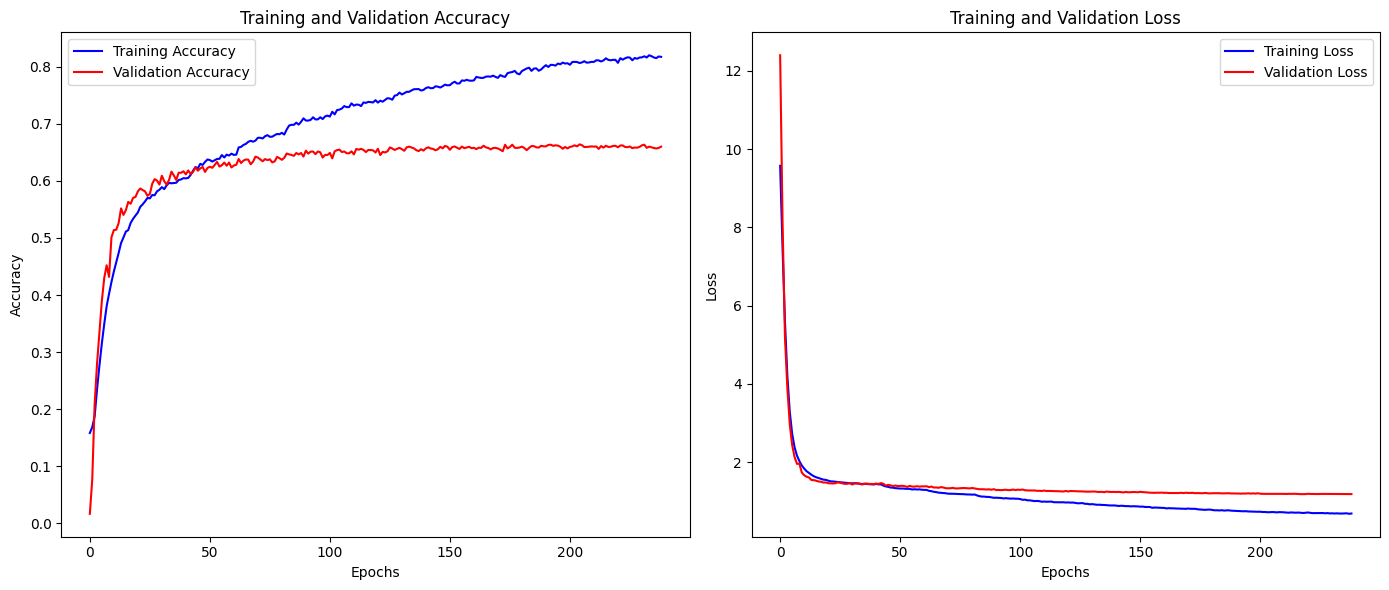

In [35]:
# --- Plot Training/Validation Accuracy and Loss Side by Side ---

# Extract accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epochs as the range of training history
epochs = range(len(acc))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy on the first subplot
axes[0].plot(epochs, acc, 'b', label='Training Accuracy')  # Plot training accuracy (blue)
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')  # Plot validation accuracy (red)
axes[0].set_title('Training and Validation Accuracy')  # Title for the accuracy plot
axes[0].set_xlabel('Epochs')  # X-axis label
axes[0].set_ylabel('Accuracy')  # Y-axis label
axes[0].legend()  # Display legend

# Plot the training and validation loss on the second subplot
axes[1].plot(epochs, loss, 'b', label='Training Loss')  # Plot training loss (blue)
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')  # Plot validation loss (red)
axes[1].set_title('Training and Validation Loss')  # Title for the loss plot
axes[1].set_xlabel('Epochs')  # X-axis label
axes[1].set_ylabel('Loss')  # Y-axis label
axes[1].legend()  # Display legend

plt.tight_layout()
plt.show()

Get Predictions and Evaluate Performance


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


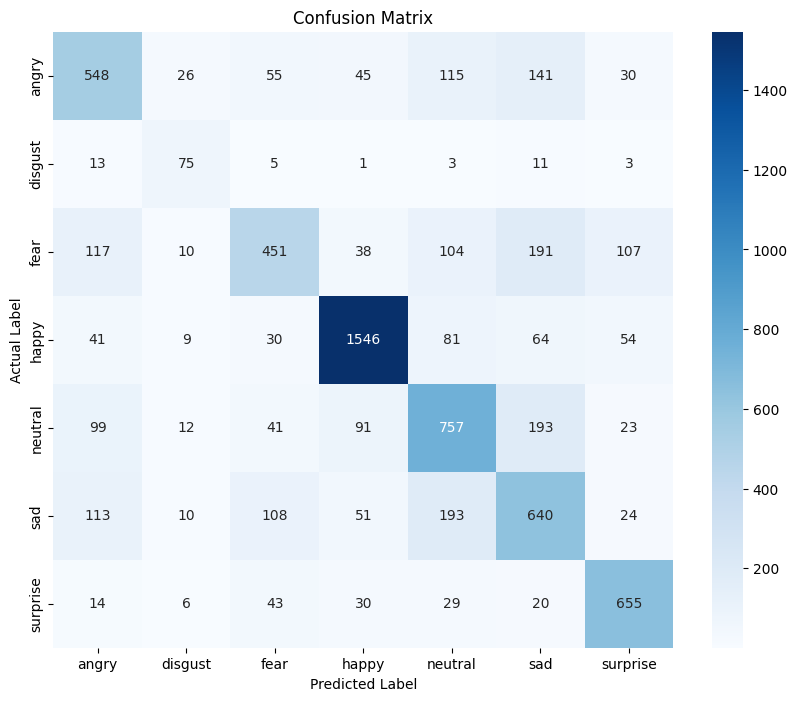

Classification Report:
               precision    recall  f1-score   support

       angry       0.58      0.57      0.58       960
     disgust       0.51      0.68      0.58       111
        fear       0.62      0.44      0.52      1018
       happy       0.86      0.85      0.85      1825
     neutral       0.59      0.62      0.61      1216
         sad       0.51      0.56      0.53      1139
    surprise       0.73      0.82      0.77       797

    accuracy                           0.66      7066
   macro avg       0.63      0.65      0.63      7066
weighted avg       0.66      0.66      0.66      7066



In [36]:
# Get model predictions for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert true labels from one-hot encoding to class labels

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)  # Compare predicted and true labels
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")  # Title for confusion matrix plot
plt.ylabel("Actual Label")  # Label for y-axis
plt.xlabel("Predicted Label")  # Label for x-axis
plt.show()  # Display the confusion matrix plot

# Generate and print Classification Report
report = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print("Classification Report:\n", report)  # Print detailed classification metrics

Making Random Prediction

Original output:  angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction Output:  ['angry']


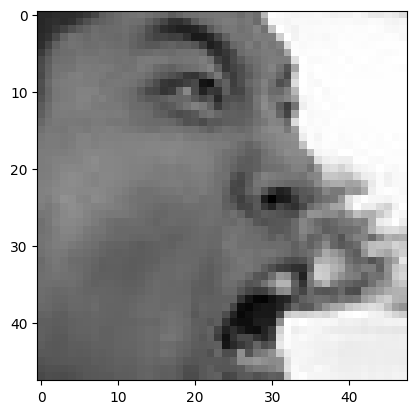

In [44]:
image_index = random.randint(0, len(test))
print("Original output: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])
print("Prediction Output: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')